
### Basic Data Plotting

One of the most fundamental tasks in data analysis/modeling is to read data from files and plot them. In this section, we will learn how to read data from files and plot them using `matplotlib`.

Let's begin by importing the necessary libraries.


In [1]:
import csv
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

We will use the `csv` library to read data from files, `matplotlib` to plot data, `scipy` to fit data to a function, and `numpy` to perform numerical operations.

Let's write a function to read data from a CSV file. The function takes the filename as input and returns five lists: the (string) header label for each column in the data file, the x data, the y data, the error in x values, and the error in y values. The function assumes that the first row of the CSV file contains the column headers.

In [2]:
def read_data(filename):
    x = []
    y = []
    dx = []
    dy = []

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader, None)
        for row in reader:
            x.append(float(row[0]))
            y.append(float(row[1]))
            dx.append(float(row[2]))
            dy.append(float(row[3]))

    return headers, x, y, dx, dy

Next, we will write a 'main program'.  We wil read in the data (using the function above), and then plot the data, with error bars, and with appropriate axis labels and title.  We will also make sure that the lower limit of the y-axis is zero.  Finally, we will choose logarithmic x and/or y scales if appropriate.

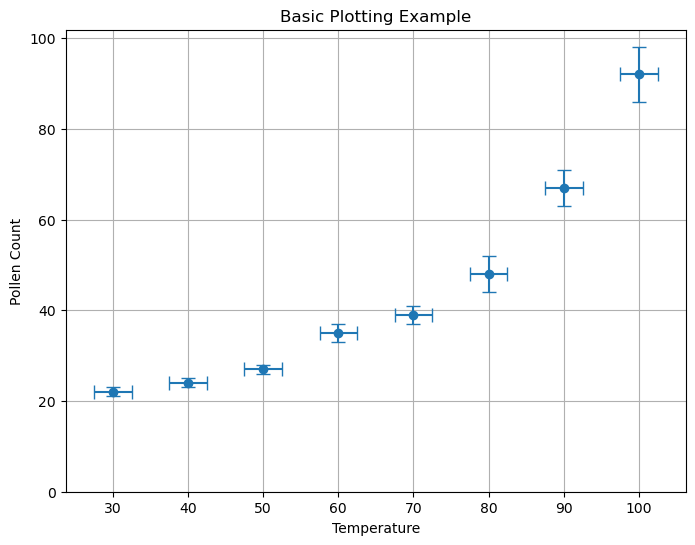

In [3]:
# Step 1:  Read the data into appropriate data structures
file_name = "testdata.csv"
header_values, xi, yi, dxi, dyi = read_data(file_name)

# print(header_values)
# print(xi, yi, dxi, dyi)

# Step 2: Basic plot of the data with error bars, plot title, and axis labels
fig, ax = plt.subplots(1,1, figsize=(8, 6))
ax.errorbar(xi, yi, xerr=dxi, yerr=dyi, fmt='o', label="Pollen Count Data", capsize=5.0)
ax.set_title("Basic Plotting Example")
ax.set_xlabel(header_values[0])
ax.set_ylabel(header_values[1])

# Make sure lower limit of y-axis is zero!
ax.set_ylim(0)
ax.grid()

# Possibly, choose logarithmic x and/or y scales.
# plt.xscale('log')
# plt.yscale('log')

Now, we can fit the data!  We define an appropriate fitting function (two, in this case - one for a quadratic fit and one for an exponential fit), and then use the `curve_fit` function from `scipy` to fit the data.  We also print out the fit parameters and their uncertainties, and the covariance matrix.

In [12]:
# Step 3a: Define a quadratic fit function
def fitfunction(x, *param):
    return param[0]*x*x + param[1]*x + param[2]

# Step 3a: Define an exponential+bkgd fit function
def expfunction(x, *param):
    return param[0]*np.exp(param[1]*x) + param[2]

fitchoice = 2

if fitchoice == 1:
    # Step 3b:  Fit the data with quadratic
    init_vals = [0 for x in range(3)]
    popt, pcov = curve_fit(fitfunction, xi, yi, p0=init_vals, sigma=dyi, absolute_sigma=True)
else:
    # Step 3b:  Fit the data with exponential + background
    init_vals = [1.0, 0.01, 10.00]  # N.B. need to choose initial guesses that make sense!!!
    popt, pcov = curve_fit(expfunction, xi, yi, p0=init_vals, sigma=dyi, absolute_sigma=True)

perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr)
print(pcov)

[ 1.33225935  0.04012304 17.48103172]
[0.62438822 0.00485997 2.05429646]
[[ 3.89860643e-01 -3.01327602e-03 -1.22232868e+00]
 [-3.01327602e-03  2.36192601e-05  9.25374983e-03]
 [-1.22232868e+00  9.25374983e-03  4.22013396e+00]]


Extract the fit parameters and their uncertainties from the fit result, and print them out, in an nicer format.

In [13]:
a = popt[0]
b = popt[1]
c = popt[2]
da = perr[0]
db = perr[1]
dc = perr[2]
if fitchoice == 1:
    print(f'Fit Result: y = ({a:.5f} +/- {da:.5f})x^2 + ({b:.5f} +/- {db:.5f})x + ({c:.5f} +/- {dc:.5f})')
else:
    print(f'Fit Result: y = ({a:.5f} +/- {da:.5f})e(({b:.5f} +/- {db:.5f})x) + ({c:.5f} +/- {dc:.5f})')

Fit Result: y = (1.33226 +/- 0.62439)e((0.04012 +/- 0.00486)x) + (17.48103 +/- 2.05430)


Plot the fit result on top of the data.

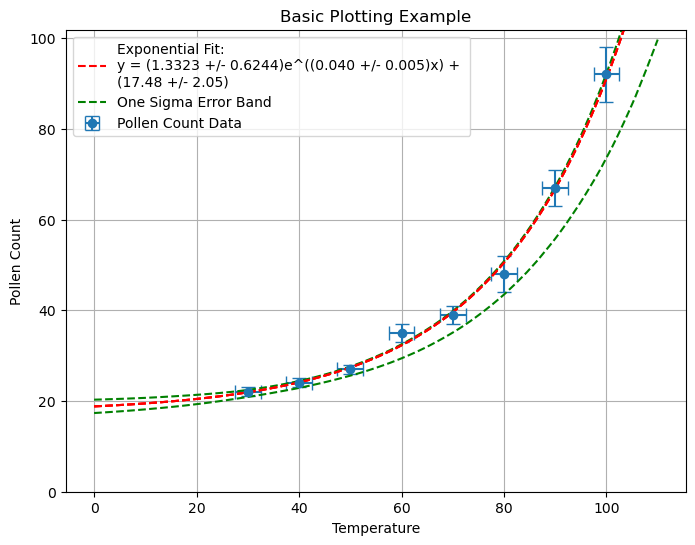

In [14]:
# Step 3d:  Plot the fit result
xlow = min(xi) - 30
xhigh = max(xi) + 10
xfit = np.linspace(xlow, xhigh, 100)

if fitchoice == 1:
    yfit = fitfunction(xfit, *popt)
    ax.plot(xfit, yfit, 'r--', label=f"Quadratic Fit: \ny = ({a:.4f} +/- {da:.4f})x^2 + \n({b:.2f} +/- {db:.2f})x + \n({c:.2f} +/- {dc:.2f})")

else:
    yfit = expfunction(xfit, *popt)
    ax.plot(xfit, yfit, 'r--', label=f"Exponential Fit: \ny = ({a:.4f} +/- {da:.4f})e^(({b:.3f} +/- {db:.3f})x) + \n({c:.2f} +/- {dc:.2f})")

ax.grid()

fig


We will also plot the error band, which is the region within which 68% of the fits lie.  This is a good way to visualize the uncertainty in the fit.

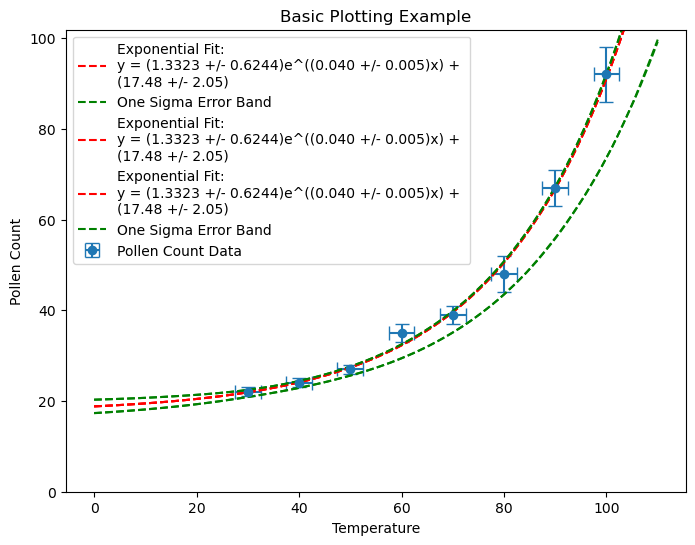

In [15]:
# Step 4:  Plot the error band
plot_error_band = True

if plot_error_band:
    ps = np.random.multivariate_normal(popt,pcov,10000)
    if fitchoice == 1:
        ysample = np.asarray([fitfunction(xfit, *pi) for pi in ps])
    else:
        ysample = np.asarray([expfunction(xfit, *pi) for pi in ps])

    lower = np.percentile(ysample, 16.0, axis=0)
    upper = np.percentile(ysample, 84.0, axis=0)
    middle = (upper+lower)/2.0
    ax.plot(xfit,upper,'g--', label='One Sigma Error Band')
    ax.plot(xfit,lower,'g--')
    #if fitchoice == 2:
    #    ax.plot(xfit, middle, 'r--', label=f"Exponential Fit: \ny = ({a:.4f} +/- {da:.4f})e^(({b:.3f} +/- {db:.3f})x) + \n({c:.2f} +/- {dc:.2f})")


    ax.legend()
    ax.grid()

fig

In [16]:
# Calculate Goodness of Fit:
if fitchoice == 1:
    yfit2 = fitfunction(np.array(xi), *popt)
else:
    yfit2 = expfunction(np.array(xi), *popt)

chi2 = 0.0
for i in range(len(xi)):
    # print(yi[i],yfit2[i],dyi[i])
    chi2 += (yi[i]-yfit2[i])**2/dyi[i]**2

print(f"Goodness of Fit (reduced chi^2) = {chi2/(len(xi)-1-len(init_vals))}")

Goodness of Fit (reduced chi^2) = 0.6296594341126811
